In [1]:
import sys
from pathlib import Path

project_root = Path(".").resolve().parent.parent
sys.path.append(str(project_root))

import numpy as np
import matplotlib.pyplot as plt

from context_exploration.data.envs import make_env

file_suffix = ""

SMALL_SIZE = 8
MEDIUM_SIZE = 8
BIGGER_SIZE = 8

figwidth_half_in = 4.5
figwidth_full_in = 6.47

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=MEDIUM_SIZE)  # fontsize of the figure title

plt.rc("font", **{"family": "serif"})
plt.rc("text", usetex=True)

plt.rc("text.latex", preamble="\\usepackage{amsmath}")

[2.77853385e+00 9.22132874e+02 7.29613538e-01 4.40000000e+01]
[1.55524623e+00 9.65770433e+02 7.64872023e-01 4.00000000e+01]


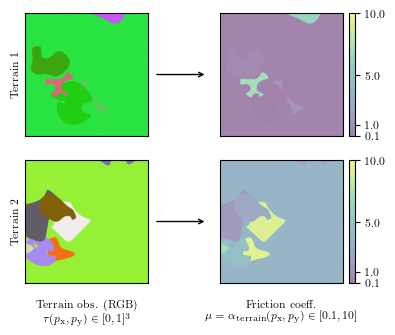

In [2]:
# Plot exemplary landscapes

fig, ax_arr = plt.subplots(
    nrows=2, ncols=2, figsize=(figwidth_half_in, 3.5), squeeze=False
)

env = make_env("unicycle_robotvary_terrainpatches", reset_split="train")

env.initialize_context(0)
print(env.context)
env.seed(0)

env.plot_landscape(ax_arr[0, 0])
ims = env.plot_friction(ax_arr[0, 1], alpha=0.5)
fig.colorbar(ims, ax=ax_arr[0, 1], ticks=[0.1, 1, 5, 10], fraction=0.046, pad=0.04)

env.release_context()

env.initialize_context(2)
print(env.context)
env.seed(0)

env.plot_landscape(ax_arr[1, 0])
ims = env.plot_friction(ax_arr[1, 1], alpha=0.5)
fig.colorbar(ims, ax=ax_arr[1, 1], ticks=[0.1, 1, 5, 10], fraction=0.046, pad=0.04)

env.release_context()


for ax in ax_arr.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

ax_arr[0, 0].set_ylabel("Terrain 1")
ax_arr[1, 0].set_ylabel("Terrain 2")

ax_arr[1, 0].set_xlabel(
    "\nTerrain obs. (RGB)\n ${\\tau}(p_\mathrm{x}, p_\mathrm{y}) \\in [0, 1]^3$"
)
ax_arr[1, 1].set_xlabel(
    "\nFriction coeff.\n $\\mu = \\alpha_\\mathrm{terrain}(p_\mathrm{x}, p_\mathrm{y}) \\in [0.1, 10]$"
)

endpoint = 1.485

ax_arr[0, 0].annotate(
    "",
    xy=(endpoint, 0.5),
    xycoords="axes fraction",
    xytext=(1.05, 0.5),
    textcoords="axes fraction",
    arrowprops=dict(arrowstyle="->"),
)
ax_arr[1, 0].annotate(
    "",
    xy=(endpoint, 0.5),
    xycoords="axes fraction",
    xytext=(1.05, 0.5),
    textcoords="axes fraction",
    arrowprops=dict(arrowstyle="->"),
)

plt.subplots_adjust(wspace=0.2)

plt.savefig(f"generated/terrain.png", bbox_inches="tight", pad_inches=0)

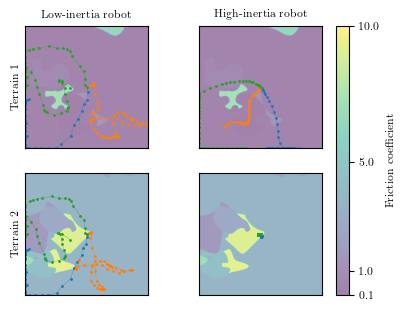

In [3]:
# Plot exemplary rollouts

n_transitions = 50

fig, ax_arr = plt.subplots(
    nrows=2, ncols=2, figsize=(figwidth_half_in, 3.5), squeeze=False
)

actions = {}

# mass, k_thr, k_steer
robot_parameter_list = [
    np.array([1, 1000, np.pi / 4]),
    np.array([4, 500, np.pi / 8]),
]
for row, terrain_profile in enumerate(
    [
        44,
        40,
    ]
):
    for col, robot_parameter in enumerate(robot_parameter_list):
        context = np.concatenate((robot_parameter, np.array([terrain_profile])))
        env.initialize_context(seed=None, context=context)

        ims = env.plot_friction(ax_arr[row, col], alpha=0.5)
        ax_arr[row, col].set_xticks([])
        ax_arr[row, col].set_yticks([])

        for action_seed in [0, 1, 2]:

            action_iterator = env.excitation_controller.get_iterator(action_seed)
            obs = env.reset(init_robot_state=np.array([0.5, 0.5, 0, 0]))
            obs_list = [
                obs,
            ]
            act_list = []
            for _ in range(n_transitions):
                action = next(action_iterator)
                act_list.append(action)
                obs, _, _, _ = env.step(action)
                obs_list.append(obs)

            obs_arr = np.stack(obs_list)
            act_arr = np.stack(act_list)

            actions[action_seed] = act_arr

            ax_arr[row, col].plot(obs_arr[:, 0], obs_arr[:, 1], linewidth=0.2)
            ax_arr[row, col].scatter(obs_arr[::, 0], obs_arr[::, 1], s=1)

        env.release_context()

ax_arr[0, 0].set_ylabel("Terrain 1")
ax_arr[1, 0].set_ylabel("Terrain 2")

ax_arr[0, 0].set_title("Low-inertia robot", fontsize=MEDIUM_SIZE)
ax_arr[0, 1].set_title("High-inertia robot", fontsize=MEDIUM_SIZE)

cbar = fig.colorbar(
    ims, ticks=[0.1, 1, 5, 10], ax=ax_arr.ravel().tolist(), fraction=0.046, pad=0.04
)
cbar.set_label("Friction coefficient")

plt.savefig(f"generated/rollouts.png", bbox_inches="tight", pad_inches=0)